## Neural Network

I feel that my work in trying to solve this problem would not be complete without attempting to throw a neural network at it, so let's give it a shot.

## Imports

In [9]:
import os
import sys
import joblib

sys.path.append(os.path.abspath(".."))
from src.process_data import processData

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt


## Load and Clean Data

In [2]:
path = os.path.join('..', 'data', 'train.csv')
data = pd.read_csv(path)
data = processData(data)
data.head()

/Users/eaglehawkinator/Coding Projects/DreamersInc-Interview-Code/src/process_data.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['closing_return'].fillna(0, inplace=True)


,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target,closing_return,spread
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,True,0.000000,0.00010
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,False,0.000721,0.00010
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,False,-0.000621,0.00001
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,False,0.000000,0.00002
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,False,-0.000100,0.00009


In [3]:
def create_nn_data(data, batch_size=10, save_scaler=True):
    X = data.drop(columns=['target']).values
    y = data['target'].values
    y = y[:len(y) - len(y) % batch_size : batch_size]
    y = y.reshape(-1, 1, 1)

    X = X[:len(X) - len(X) % batch_size]
    
    scaler_path = os.path.join('..', 'trained-models', 'scaler.joblib')
    if save_scaler:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        joblib.dump(scaler, scaler_path)
    else:
        scaler = joblib.load(scaler_path)
        X = scaler.transform(X)

    X = X.reshape(-1, batch_size, X.shape[1])
    

    return X, y

In [4]:
BATCH_SIZE = 5
X, y = create_nn_data(data, batch_size=BATCH_SIZE)

X.shape, y.shape

((424487, 5, 12), (424487, 1, 1))

## Build the Model

In [5]:
model = Sequential()
model.add(SimpleRNN(32, activation='relu', return_sequences=True))  # 50 RNN units
model.add(BatchNormalization())
model.add(SimpleRNN(32, activation='relu'))  # 50 RNN units
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
model.fit(X, y, epochs=10)

Epoch 1/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.5419 - loss: 0.6882
Epoch 2/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.7622 - loss: 0.5034
Epoch 3/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8672 - loss: 0.2949
Epoch 4/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8869 - loss: 0.2474
Epoch 5/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.8969 - loss: 0.2264
Epoch 6/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9028 - loss: 0.2150
Epoch 7/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9047 - loss: 0.2095
Epoch 8/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9075 - loss: 0.2017
Epoch 9/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9076 - loss: 0.2025
Epoch 10/10
13266/13266 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9107 - loss: 0.1953


## Plot Results

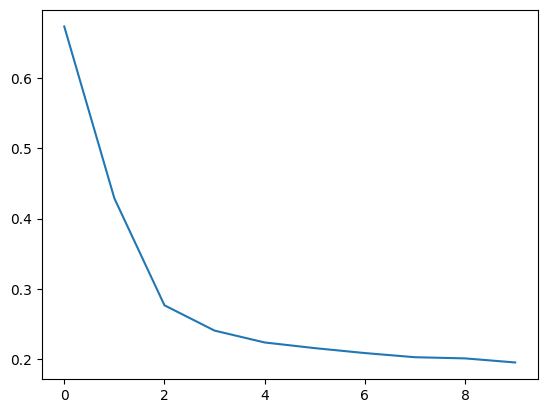

In [143]:
plt.plot(model.history.history['loss'])
plt.show()

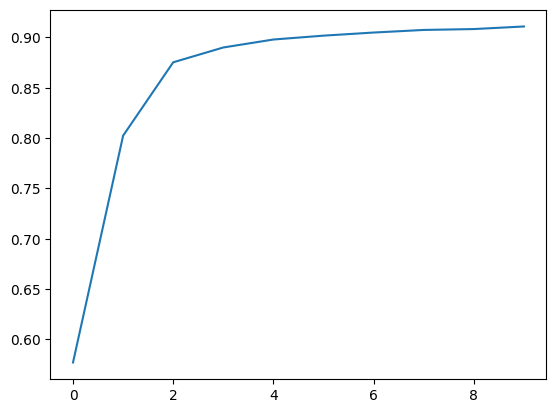

In [144]:
plt.plot(model.history.history['accuracy'])
plt.show()

I ran into some issues originally, but after applying a MinMax scaler we actually get very good signs from these training graphs. It could still be overfitting, but we are at least fitting the training data very well.

## Save the models for later

In [145]:
model_path = os.path.join('..', 'trained-models', 'neural-net.keras')
model.save(model_path)

## Evaluate out of sample performance

Now we can try the neural net on our out of sample data, is it just wildly overfit (likely), or does it actually provide a good predictor for next-period price?

In [43]:
test = pd.read_csv(os.path.join('..', 'data', 'test.csv'))
test = processData(test)
actual = test['target'].copy()
row_id = test['row_id'].copy()
test = test.drop(columns=['row_id', 'target'])
test.head()

/Users/eaglehawkinator/Coding Projects/DreamersInc-Interview-Code/src/process_data.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['closing_return'].fillna(0, inplace=True)


,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,closing_return,spread
0,1652817480,0.4306,0.4308,0.4301,0.4301,101150.0,43542.2629,105.0,46109.0,19851.7237,0.000000,0.0007
1,1652817540,0.4301,0.4303,0.4293,0.4302,275647.0,118478.9689,228.0,91260.0,39217.6312,0.000233,0.0010
2,1652817600,0.4302,0.4302,0.4292,0.4299,134959.0,57979.2418,156.0,56685.0,24357.5448,-0.000697,0.0010
3,1652817660,0.4299,0.4303,0.4299,0.4301,316209.0,135979.4040,121.0,161740.0,69552.2691,0.000465,0.0004
4,1652817720,0.4302,0.4307,0.4302,0.4303,107440.0,46243.7993,113.0,31096.0,13384.3384,0.000465,0.0005


In [29]:
test = test.values
scaler = joblib.load(os.path.join('..', 'trained-models', 'scaler.joblib'))
test = scaler.transform(test)

In [30]:
X_test = []
for i in range(len(test) - BATCH_SIZE):
    X_test.append(test[i:i+BATCH_SIZE])
X_test = np.array(X_test)
X_test.shape

(909612, 5, 12)

In [49]:
model = load_model(os.path.join('..', 'trained-models', 'neural-net.keras'))
y_pred = model.predict(X_test)
y_pred = np.pad(y_pred.flatten(), (0, BATCH_SIZE), mode='constant', constant_values=0)

28426/28426 ━━━━━━━━━━━━━━━━━━━━ 16s 569us/step


In [50]:
submission = pd.DataFrame({'row_id': row_id, 'target': y_pred.flatten()})
submission['target'] = submission['target'].apply(lambda x: 1 if x > 0.5 else 0)
submission.head(10)

,row_id,target
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1
5,5,0
6,6,0
7,7,1
8,8,1
9,9,0


In [51]:
submission.to_csv(os.path.join('..', 'data', 'submission.csv'), index=False)

## Compare to the real target

In [56]:
submission['actual'] = actual.astype(int)
submission['correct'] = (submission['target'] == submission['actual']).astype(int)
submission.tail(20)

,row_id,target,actual,correct
909597,909597,1,1,1
909598,909598,1,1,1
909599,909599,1,1,1
909600,909600,1,1,1
909601,909601,1,1,1
909602,909602,1,0,0
909603,909603,1,1,1
909604,909604,1,1,1
909605,909605,1,0,0
909606,909606,1,1,1


In [53]:
submission['correct'].mean(), submission['actual'].mean()

(np.float64(0.5337653100150943), np.float64(0.41994927535435245))

So we actually would have done better by simply guessing 0 at every timestep. This is a clear sign of overfitting, the model performed extremely well in sample but had essentially no predictive power out of sample.